<a href="https://colab.research.google.com/github/jameslequang232/Simi-Volunteering/blob/main/Novel%20Tool%20to%20Diagnose%20Insomnia%20Using%20Machine%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving P_DIQ.xpt to P_DIQ.xpt
Saving P_BPQ.xpt to P_BPQ.xpt
Saving P_RXQ_RX.xpt to P_RXQ_RX.xpt
Saving P_GLU.XPT to P_GLU.XPT
Saving P_DR1TOT.XPT to P_DR1TOT.XPT
Saving P_BIOPRO.XPT to P_BIOPRO.XPT
Saving P_HSQ.xpt to P_HSQ.xpt
Saving RXQ_DRUG.xpt to RXQ_DRUG.xpt
Saving P_PAQ.xpt to P_PAQ.xpt
Saving P_BMX.XPT to P_BMX.XPT
Saving P_DBQ.xpt to P_DBQ.xpt
Saving P_SMQFAM.xpt to P_SMQFAM.xpt
Saving P_ALQ.xpt to P_ALQ.xpt
Saving P_MCQ.xpt to P_MCQ.xpt
Saving P_DPQ.xpt to P_DPQ.xpt
Saving P_SLQ.xpt to P_SLQ.xpt
Saving P_DEMO.xpt to P_DEMO.xpt


In [2]:
 !pip install optuna --upgrade shap xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.9 MB/s eta 0:00:00


**Training Model **

---

# XGB Optuna Model F1 Optimized

[I 2025-12-11 00:32:53,899] A new study created in memory with name: no-name-b0b573db-710b-4a06-8197-e3114a7cc247
[I 2025-12-11 00:33:02,052] Trial 0 finished with value: 0.8660038213266383 and parameters: {'n_estimators': 281, 'max_depth': 4, 'learning_rate': 0.12251600976258308, 'subsample': 0.960028866666927, 'colsample_bytree': 0.8089541005911289, 'gamma': 0.051616392143081, 'min_child_weight': 4}. Best is trial 0 with value: 0.8660038213266383.
[I 2025-12-11 00:33:03,281] Trial 1 finished with value: 0.7164185091643608 and parameters: {'n_estimators': 173, 'max_depth': 3, 'learning_rate': 0.030654533862490424, 'subsample': 0.8666782246223672, 'colsample_bytree': 0.5271015963004853, 'gamma': 0.7312188441388962, 'min_child_weight': 5}. Best is trial 0 with value: 0.8660038213266383.
[I 2025-12-11 00:33:08,478] Trial 2 finished with value: 0.9086927677983704 and parameters: {'n_estimators': 376, 'max_depth': 7, 'learning_rate': 0.04318881121390648, 'subsample': 0.6149267170260928, 'c


Best XGBoost Params: {'n_estimators': 217, 'max_depth': 8, 'learning_rate': 0.18093236128977147, 'subsample': 0.6340992655258514, 'colsample_bytree': 0.7350048087488609, 'gamma': 0.16330528486368323, 'min_child_weight': 3}
✅ Raw pipeline saved for SHAP

Best Threshold (F1): 0.515

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3166
           1       0.96      0.92      0.94      2213

    accuracy                           0.95      5379
   macro avg       0.95      0.95      0.95      5379
weighted avg       0.95      0.95      0.95      5379

✅ Calibrated classifier saved for API


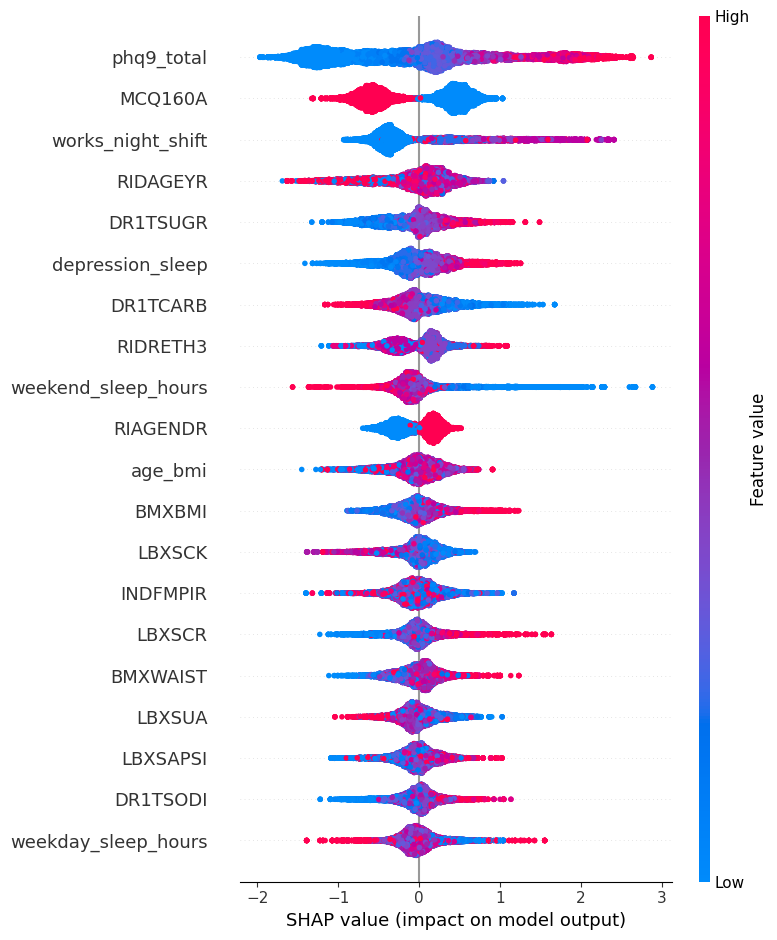

✅ SHAP analysis completed and saved


In [3]:
# --- Imports  Model without SHAP Works Very Well Current---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
import optuna
import joblib
import json

# =========================================================
# 1. Load & Merge NHANES Data
# =========================================================
df_demo = pd.read_sas("/content/P_DEMO.xpt")
df_sleep = pd.read_sas("/content/P_SLQ.xpt")
df_dpq = pd.read_sas("/content/P_DPQ.xpt")
df_mcq = pd.read_sas("/content/P_MCQ.xpt")
df_bpq = pd.read_sas("/content/P_BPQ.xpt")
df_rxq = pd.read_sas("/content/P_RXQ_RX.xpt")
df_alq = pd.read_sas("/content/P_ALQ.xpt")
df_bmx = pd.read_sas("/content/P_BMX.XPT")
df_smq = pd.read_sas("/content/P_SMQFAM.xpt")
df_paq = pd.read_sas("/content/P_PAQ.xpt")
df_glu = pd.read_sas("/content/P_GLU.XPT")
df_dbq = pd.read_sas("/content/P_DBQ.xpt")
df_diet = pd.read_sas("/content/P_DR1TOT.XPT")
df_bio = pd.read_sas("/content/P_BIOPRO.XPT")

# =========================================================
# 2. Feature Engineering
# =========================================================
dpq_cols = [f"DPQ0{i}" for i in range(20, 100, 10)]
df_dpq["phq9_total"] = df_dpq[dpq_cols].sum(axis=1, skipna=True)
dpq_reduced = df_dpq[["SEQN", "phq9_total"] + dpq_cols]

df_paq = df_paq[["SEQN", "PAQ605", "PAD615", "PAD630"]]
df_paq = df_paq.rename(columns={"PAQ605": "activity_limited"})

df_sleep = df_sleep.rename(
    columns={
        "SLD012": "weekday_sleep_hours",
        "SLD013": "weekend_sleep_hours",
        "SLQ030": "work_shift",
        "SLQ040": "works_night_shift",
        "SLQ050": "trouble_sleeping",
        "SLQ120": "sleep_disorder",
    }
)

df = df_demo.copy()
merge_tables = [
    df_sleep,
    dpq_reduced,
    df_mcq,
    df_alq,
    df_bmx,
    df_smq,
    df_paq,
    df_dbq,
    df_diet,
    df_bio,
    df_glu,
    df_bpq,
    df_rxq,
]
for t in merge_tables:
    df = df.merge(t, on="SEQN", how="left")

# =========================================================
# 3. Target Label
# =========================================================
df = df[df["trouble_sleeping"].notna()].copy()
df["insomnia"] = df["trouble_sleeping"].apply(lambda x: 1 if x == 1 else 0)

# =========================================================
# 4. Medication Features
# =========================================================
df["RXDDRUG"] = df["RXDDRUG"].apply(
    lambda x: x.decode("utf-8").lower() if isinstance(x, bytes) else str(x).lower()
)
sleep_meds = [
    "zolpidem",
    "ambien",
    "trazodone",
    "melatonin",
    "temazepam",
    "diphenhydramine",
    "doxylamine",
    "eszopiclone",
    "lunesta",
    "ramelteon",
]
antidepressants = [
    "fluoxetine",
    "sertraline",
    "venlafaxine",
    "citalopram",
    "escitalopram",
]
df_rx = df.groupby("SEQN")["RXDDRUG"].apply(lambda x: " ".join(x.dropna())).reset_index()
df_rx["takes_sleep_med"] = df_rx["RXDDRUG"].apply(
    lambda x: int(any(m in x for m in sleep_meds))
)
df_rx["takes_antidepressant"] = df_rx["RXDDRUG"].apply(
    lambda x: int(any(m in x for m in antidepressants))
)
df = df.merge(
    df_rx[["SEQN", "takes_sleep_med", "takes_antidepressant"]],
    on="SEQN",
    how="left",
)

# =========================================================
# 5. Feature Selection & Engineering
# =========================================================
num_cols = [
    "RIDAGEYR",
    "INDFMPIR",
    "weekday_sleep_hours",
    "weekend_sleep_hours",
    "phq9_total",
    "BMXBMI",
    "BMXWAIST",
    "PAD615",
    "PAD630",
]

df["age_bmi"] = df["RIDAGEYR"] * df["BMXBMI"]
df["income_bmi"] = df["INDFMPIR"] / (df["BMXBMI"] + 1)
df["depression_sleep"] = df["phq9_total"] + df["weekday_sleep_hours"]
df["caff_age"] = (
    df["DR1TCAFF"] * df["RIDAGEYR"] if "DR1TCAFF" in df.columns else 0
)
num_cols += ["age_bmi", "income_bmi", "depression_sleep", "caff_age"]

extra_cols = [
    "DR1TKCAL",
    "DR1TPROT",
    "DR1TCARB",
    "DR1TTFAT",
    "DR1TSUGR",
    "DR1TSODI",
    "DR1TCHOL",
    "DR1TCAFF",
    "LBXSAL",
    "LBXSAPSI",
    "LBXSASSI",
    "LBXSCK",
    "LBXSCR",
    "LBXSUA",
]
for col in extra_cols:
    if col in df.columns:
        df[f"{col}_missing"] = df[col].isna().astype(int)
        df[[col]] = SimpleImputer(strategy="mean").fit_transform(df[[col]])
        df[[col]] = StandardScaler().fit_transform(df[[col]])
        num_cols.extend([col, f"{col}_missing"])

cat_cols = [
    "RIAGENDR",
    "RIDRETH3",
    "DMDEDUC2",
    "MCQ160A",
    "ALQ130",
    "activity_limited",
    "work_shift",
    "works_night_shift",
]
for col in cat_cols:
    df[col] = df[col].astype("category").cat.codes

# Remove label-like columns to prevent leakage
label_like = ["trouble_sleeping", "sleep_disorder", "SMD460", "SMD470"]
features = [c for c in num_cols + cat_cols if c not in label_like]

X = df[features]
y = df["insomnia"]

# =========================================================
# 6. Split & Resample
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
# Basic pre-imputation before SMOTE (SMOTE can't handle NaNs)
pre_imputer = SimpleImputer(strategy="mean")
X_train_imputed = pd.DataFrame(pre_imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(pre_imputer.transform(X_test), columns=X_test.columns)

# Resample
sm = SMOTETomek(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_imputed, y_train)

# =========================================================
# 7. Optuna Hyperparameter Tuning
# =========================================================
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 400),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "eval_metric": "logloss",
        "random_state": 42,
    }
    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_train_sm, y_train_sm, cv=3, scoring="f1")
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params
print("\nBest XGBoost Params:", best_params)

# =========================================================
# 8. Build Pipeline for SHAP
# =========================================================
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import shap
import joblib

# --- Build raw pipeline (no calibration) ---
xgb_final = XGBClassifier(**best_params, random_state=42)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('xgb', xgb_final)
])

# Fit pipeline on SMOTE data
pipeline.fit(X_train_sm, y_train_sm)

# Save raw pipeline for SHAP
joblib.dump(pipeline, "xgb_pipeline_for_shap.joblib")
print("✅ Raw pipeline saved for SHAP")

# =========================================================
# 9. Calibrated classifier for API predictions
# =========================================================
from sklearn.calibration import CalibratedClassifierCV

# Fit calibrated classifier on SMOTE train set
xgb_cal = CalibratedClassifierCV(pipeline, method='isotonic', cv=5)
xgb_cal.fit(X_train_sm, y_train_sm) # Corrected to use X_train_sm for fitting CalibratedClassifierCV

# Evaluate on test set
y_proba = xgb_cal.predict_proba(X_test_imputed)[:, 1] # Corrected to use X_test_imputed

# Threshold tuning
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
best_thresh = thresholds[f1.argmax()]

y_pred = (y_proba >= best_thresh).astype(int)

from sklearn.metrics import classification_report
print(f"\nBest Threshold (F1): {best_thresh:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save calibrated model and threshold
joblib.dump(xgb_cal, "xgb_optuna_pipeline.joblib")
import json
with open("best_threshold.json", "w") as f:
    json.dump({"best_threshold": float(best_thresh)}, f)
print("✅ Calibrated classifier saved for API")

# =========================================================
# 10. SHAP analysis
# =========================================================
# Load raw pipeline if needed
pipeline = joblib.load("xgb_pipeline_for_shap.joblib")
imputer = pipeline.named_steps['imputer']
scaler = pipeline.named_steps['scaler']
xgb_model = pipeline.named_steps['xgb']

# Transform training data
X_train_transformed = imputer.transform(X_train)
X_train_transformed = scaler.transform(X_train_transformed)

# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_transformed)

# Optional: summary plot
shap.summary_plot(shap_values, X_train_transformed, feature_names=X_train.columns)

# Save SHAP artifacts
joblib.dump(explainer, "shap_explainer.joblib")
joblib.dump(shap_values, "shap_values.joblib")
print("✅ SHAP analysis completed and saved")

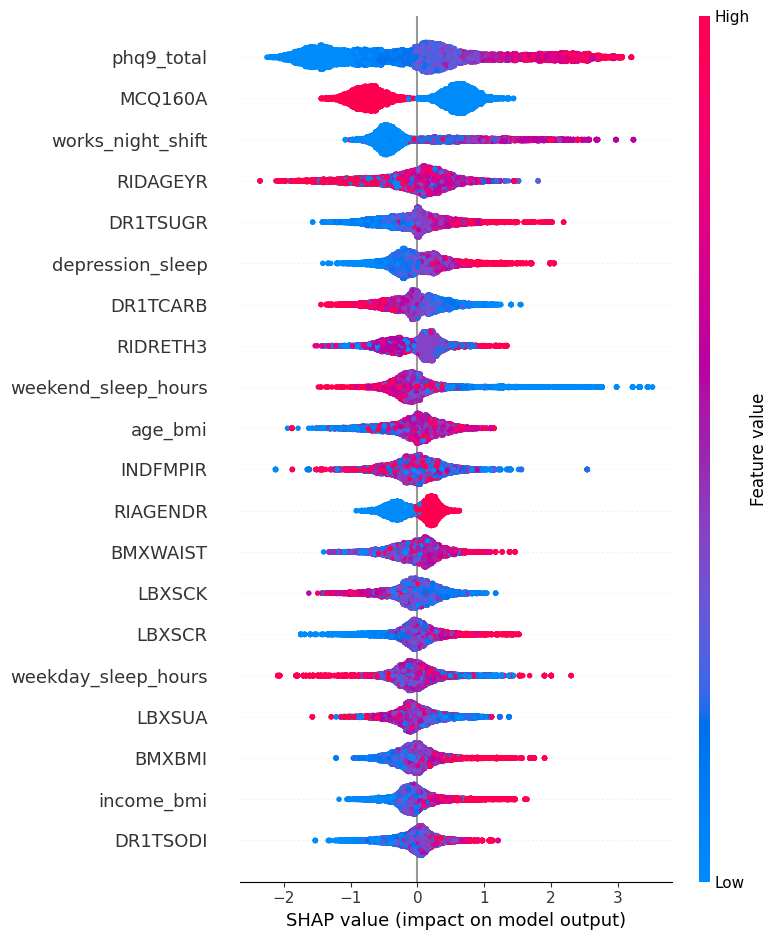

In [4]:
shap.summary_plot(shap_values, X_train_transformed, feature_names=X_train.columns)

In [ ]:
import json
with open("features_used.json", "w") as f:
    json.dump(features, f)


In [12]:
import matplotlib.pyplot as plt
print (df)
df.to_csv("full_dataset.csv", index=False)




           SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0      109266.0      66.0       2.0         1      29.0       NaN       5.0   
1      109267.0      66.0       1.0         1      21.0       NaN       2.0   
2      109268.0      66.0       1.0         1      18.0       NaN       3.0   
3      109271.0      66.0       2.0         0      49.0       NaN       3.0   
4      109271.0      66.0       2.0         0      49.0       NaN       3.0   
...         ...       ...       ...       ...       ...       ...       ...   
26888  124821.0      66.0       2.0         0      63.0       NaN       4.0   
26889  124821.0      66.0       2.0         0      63.0       NaN       4.0   
26890  124821.0      66.0       2.0         0      63.0       NaN       4.0   
26891  124822.0      66.0       2.0         0      74.0       NaN       2.0   
26892  124822.0      66.0       2.0         0      74.0       NaN       2.0   

       RIDRETH3  RIDEXMON  DMDBORN4  ...  DR1TSUGR_

In [13]:
from google.colab import files
files. download("full_dataset.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

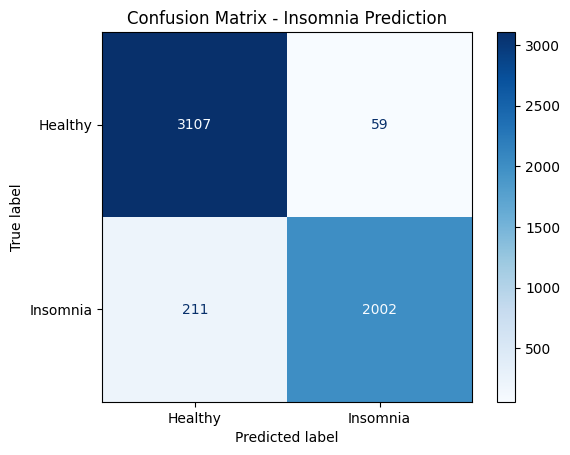

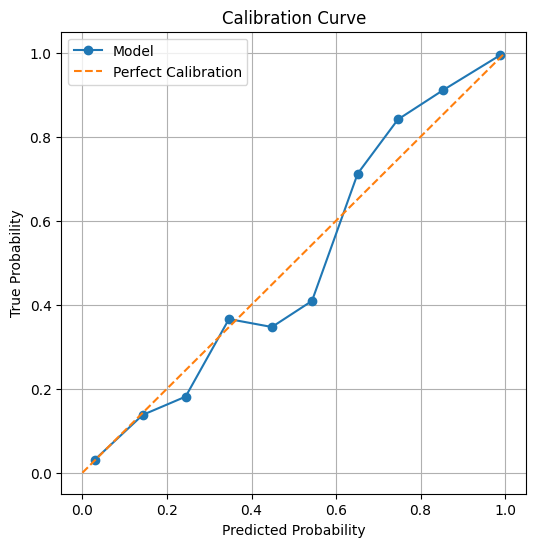

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve # Corrected import

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Insomnia"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Insomnia Prediction")
plt.show()

# --- Calibration Curve ---
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.legend()
plt.grid()
plt.show()

In [ ]:
!pip install fastapi uvicorn joblib streamlit


# Deployment


In [ ]:
 #- Desciptions for Main.py -#

 "RIDAGEYR": "Age in years",
    "RIAGENDR": "Gender (1=Male, 2=Female)",
    "INDFMPIR": "Family income-to-poverty ratio",
    "weekday_sleep_hours": "Average weekday sleep hours",
    "weekend_sleep_hours": "Average weekend sleep hours",
    "SLD012": "Trouble falling asleep (0=No, 1=Yes)",
    "SLD013": "Trouble staying asleep (0=No, 1=Yes)",
    "SMD460": "Ever told had trouble sleeping",
    "SMD470": "Ever told had insomnia",
    "PHQ9_total": "Total PHQ-9 depression score",
    "PHQ9_Q1": "PHQ-9: Little interest/pleasure",
    "PHQ9_Q2": "PHQ-9: Feeling down/depressed",
    "PHQ9_Q3": "PHQ-9: Trouble sleeping",
    "PHQ9_Q4": "PHQ-9: Feeling tired",
    "PHQ9_Q5": "PHQ-9: Poor appetite/overeating",
    "PHQ9_Q6": "PHQ-9: Feeling bad about self",
    "PHQ9_Q7": "PHQ-9: Trouble concentrating",
    "PHQ9_Q8": "PHQ-9: Moving/speaking slowly",
    "PHQ9_Q9": "PHQ-9: Thoughts of self-harm",
    "BMXBMI": "Body Mass Index (BMI)",
    "BMXWAIST": "Waist circumference (cm)",
    "BPXSY1": "Systolic blood pressure (mmHg)",
    "BPXDI1": "Diastolic blood pressure (mmHg)",
    "LBXTC": "Total cholesterol (mg/dL)",
    "LBXGLU": "Fasting blood glucose (mg/dL)",
    "LBXGH": "Glycohemoglobin (HbA1c %)",
    "LBXHCT": "Hematocrit (%)",
    "LBXWBCSI": "White blood cell count (1000/uL)",
    "LBXPLTSI": "Platelet count (1000/uL)",
    "MCQ010": "Ever told had asthma (0=No,1=Yes)",
    "MCQ160A": "Ever told had arthritis",
    "MCQ160B": "Ever told had heart failure",
    "MCQ160C": "Ever told had coronary heart disease",
    "MCQ160D": "Ever told had angina",
    "MCQ160E": "Ever told had heart attack",
    "MCQ160F": "Ever told had stroke",
    "MCQ160G": "Ever told had emphysema",
    "MCQ160K": "Ever told had cancer/malignancy",
    "PAD615": "Minutes of moderate physical activity/week",
    "PAD630": "Minutes of vigorous physical activity/week",
    "PAQ605": "Walking/biking for transportation (Yes/No)",
    "SMQ020": "Current smoking status",
    "SMQ040": "Ever smoked at least 100 cigarettes",
    "ALQ101": "Had at least 12 alcohol drinks lifetime",
    "ALQ120Q": "Days drank alcohol in past 12 months",
    "DR1TKCAL": "Daily total calorie intake",
    "DR1TPROT": "Daily protein intake (g)",
    "DR1TCARB": "Daily carbohydrate intake (g)",
    "DR1TSUGR": "Daily total sugar intake (g)",
    "DR1TTFAT": "Daily total fat intake (g)",
    "DR1TSODI": "Daily sodium intake (mg)",
    "RXDUSE": "Currently taking prescription meds",

SyntaxError: illegal target for annotation (ipython-input-957397779.py, line 1)

In [ ]:
import pandas as pd
import json

with open ("features_used.json", "r") as f:
  features = json.load(f)

X_train_df = pd.DataFrame(X_train, columns=features)
X_train_df.head(100).to_csv("X_train_sample.csv", index= False)
print("Saved X_train_sample.csv with shape", X_train_df.head(100).shape)

Saved X_train_sample.csv with shape (100, 49)


In [ ]:
import shap
import joblib
import pandas as pd
import json

# Load calibrated model
model = joblib.load("xgb_optuna_pipeline.joblib")  # update path as needed

# Extract one of the raw estimators (e.g., the first one)
raw_model = model.calibrated_classifiers_[0].estimator

# Load feature list
with open("features_used.json", "r") as f:
    features = json.load(f)

# Load a sample of your training data
X_train_sample = pd.read_csv("X_train_sample.csv")[features]

# Create SHAP explainer
explainer = shap.Explainer(raw_model, X_train_sample)

# Save explainer
joblib.dump(explainer, "explainer.pkl")

print(" SHAP explainer created and saved.")


TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.5841968638274991, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=0.085...379613, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.2615355449597098, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=370, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
import pandas as pd
import joblib

# Suppose X_raw is your original DataFrame
numeric_means = df.select_dtypes(include=["number"]).mean().to_dict()

# For categorical features → use mode
categorical_modes = {
    col: df[col].mode()[0]
    for col in df.select_dtypes(exclude=["number"]).columns
}

# Merge them
feature_defaults = {**numeric_means, **categorical_modes}

# Save
joblib.dump(feature_defaults, "feature_means.pkl")



['feature_means.pkl']

In [ ]:
feature_names = [
    "RIDAGEYR", "INDFMPIR", "weekday_sleep_hours", "weekend_sleep_hours",
    "phq9_total", "BMXBMI", "BMXWAIST",
    "PAD615", "PAD630",
    "age_bmi", "income_bmi", "depression_sleep", "caff_age",
    "DR1TKCAL", "DR1TKCAL_missing",
    "DR1TPROT", "DR1TPROT_missing",
    "DR1TCARB", "DR1TCARB_missing",
    "DR1TTFAT", "DR1TTFAT_missing",
    "DR1TSUGR", "DR1TSUGR_missing",
    "DR1TSODI", "DR1TSODI_missing",
    "DR1TCHOL", "DR1TCHOL_missing",
    "DR1TCAFF", "DR1TCAFF_missing",
    "LBXSAL", "LBXSAL_missing",
    "LBXSAPSI", "LBXSAPSI_missing",
    "LBXSASSI", "LBXSASSI_missing",
    "LBXSCK", "LBXSCK_missing",
    "LBXSCR", "LBXSCR_missing",
    "LBXSUA", "LBXSUA_missing",
    "RIAGENDR", "RIDRETH3", "DMDEDUC2",
    "MCQ160A", "ALQ130",
    "activity_limited", "work_shift", "works_night_shift"
]
joblib.dump(feature_names, "clean_feature_names.pkl")

['clean_feature_names.pkl']

In [ ]:
import pickle

# Load existing feature means
with open("feature_means.pkl", "rb") as f:
    feature_means = pickle.load(f)

with open("clean_feature_names.pkl", "rb") as f:
    clean_feature_names = pickle.load(f)

# Optionally, filter or modify it here
# e.g., keep only the 52 features your model expects
filtered_means = {k: v for k, v in feature_means.items() if k in clean_feature_names}

# Save under a new name
with open("feature_means_52.pkl", "wb") as f:
    pickle.dump(feature_means, f)

print("✅ Saved feature means as feature_means_49.pkl")


✅ Saved feature means as feature_means_49.pkl


In [ ]:
import pickle

# Load your existing means
with open("feature_means.pkl", "rb") as f:
    feature_means = pickle.load(f)

# Keep only the 52 features the model expects
filtered_means = {k: v for k, v in feature_means.items() if k in feature_names}

print(len(filtered_means))  # should now be 52

# Save it back if you want
with open("feature_means_52.pkl", "wb") as f:
    pickle.dump(filtered_means, f)


49


In [ ]:
import pickle

# Load your existing means
with open("feature_means_52.pkl", "rb") as f:
    feature_means_52 = pickle.load(f)

# Keep only the 52 features the model expects
filtered_means = {k: v for k, v in feature_means_52.items() if k in feature_names}

print(len(filtered_means))  # should now be 52

# Save it back if you want
with open("feature_means_52.pkl", "wb") as f:
    pickle.dump(filtered_means, f)


49


In [ ]:
# clean_feature_means.py
import joblib
import numpy as np

def convert_time_to_minutes(value):
    """Convert 'HH:MM' strings/bytes to minutes; keep numerics as-is."""
    if isinstance(value, (bytes, bytearray)):
        value = value.decode("utf-8")
    if isinstance(value, str) and ":" in value:
        try:
            h, m = map(int, value.split(":"))
            return h * 60 + m
        except:
            return np.nan
    try:
        return float(value)
    except:
        return np.nan

print("🔹 Loading feature_means.pkl ...")
feature_means = joblib.load("feature_means.pkl")

cleaned = {k: convert_time_to_minutes(v) for k, v in feature_means.items()}

print("✅ Cleaned. Example values:")
for k, v in list(cleaned.items())[:10]:
    print(f"{k}: {v}")

joblib.dump(cleaned, "feature_means.pkl")
print("💾 Saved cleaned feature_means.pkl")


🔹 Loading feature_means.pkl ...
✅ Cleaned. Example values:
SEQN: 117067.44130442866
SDDSRVYR: 66.0
RIDSTATR: 1.9272301342356748
RIAGENDR: 0.5264566987691964
RIDAGEYR: 57.59442977726546
RIDAGEMN: nan
RIDRETH1: 3.255903023091511
RIDRETH3: 2.3098203993604285
RIDEXMON: 1.491738851459737
DMDBORN4: 1.239876547800543
💾 Saved cleaned feature_means.pkl


In [ ]:
import pickle

# Load your full feature means
with open("feature_means_52.pkl", "rb") as f:
    feature_means = pickle.load(f)

# Suppose this is your 52-feature list
with open("clean_feature_names.pkl", "rb") as f:
    feature_names_52 = pickle.load(f)

# Keep only the 52 features your model expects
filtered_means = {k: feature_means[k] for k in feature_names if k in feature_means}

# Save as a new pickle file
with open("cleaned_feature_means.pkl", "wb") as f:
    pickle.dump(filtered_means, f)

print(f"✅ Saved {len(filtered_means)} feature means to 'cleaned_feature_means.pkl'")


✅ Saved 49 feature means to 'cleaned_feature_means.pkl'


In [ ]:
# main.py
from fastapi import FastAPI
from pydantic import create_model, Field
import pandas as pd
import joblib
import json
import numpy as np
import pickle
from typing import Any

app = FastAPI(title="Insomnia Prediction API with SHAP (defaults from training)")

# -----------------------------
# 1. Load artifacts (calibrated model + raw pipeline + SHAP + metadata)
# -----------------------------
# calibrated classifier used for predict_proba
calibrated = joblib.load("xgb_optuna_pipeline.joblib")

# raw pipeline (imputer + scaler + xgb) used for SHAP transforms
shap_pipeline = joblib.load("xgb_pipeline_for_shap.joblib")

# SHAP explainer (TreeExplainer built on the raw XGB model)
explainer = joblib.load("shap_explainer.joblib")

# feature order used for training
with open("features_used.json", "r") as f:
    feature_names = json.load(f)

# feature means / defaults
with open("cleaned_feature_means.pkl", "rb") as f:
    feature_means = pickle.load(f)

# tuned threshold
with open("best_threshold.json", "r") as f:
    best_thresh = json.load(f)["best_threshold"]

# optional feature descriptions (extend as needed)
feature_descriptions = {
    "RIDAGEYR": "Age in years",
    "RIAGENDR": "Gender (1=Male, 2=Female)",
    "INDFMPIR": "Family income-to-poverty ratio",
    "weekday_sleep_hours": "Average weekday sleep hours",
    "weekend_sleep_hours": "Average weekend sleep hours",
    "phq9_total": "Total PHQ-9 depression score (0-27)",
    "BMXBMI": "Body Mass Index (BMI, kg/m²)",
    "BMXWAIST": "Waist circumference (cm)",
    "PAD615": "Minutes of moderate physical activity per week",
    "PAD630": "Minutes of vigorous physical activity per week",
    "age_bmi": "Interaction term: Age × BMI",
    "income_bmi": "Interaction term: Income-to-poverty ratio ÷ BMI",
    "depression_sleep": "Interaction term: PHQ-9 score + average sleep hours",
    "caff_age": "Interaction term: Daily caffeine intake × Age",
    "DR1TKCAL": "Total daily energy intake (kcal)",
    "DR1TPROT": "Daily protein intake (g)",
    "DR1TCARB": "Daily carbohydrate intake (g)",
    "DR1TTFAT": "Daily total fat intake (g)",
    "DR1TSUGR": "Daily total sugar intake (g)",
    "DR1TSODI": "Daily sodium intake (mg)",
    "DR1TCHOL": "Daily cholesterol intake (mg)",
    "DR1TCAFF": "Daily caffeine intake (mg)",
    "LBXSAL": "Serum albumin (g/dL)",
    "LBXSAPSI": "Alkaline phosphatase (IU/L)",
    "LBXSASSI": "Aspartate aminotransferase (AST, IU/L)",
    "LBXSCK": "Creatine kinase (IU/L)",
    "LBXSCR": "Serum creatinine (mg/dL)",
    "LBXSUA": "Serum uric acid (mg/dL)",
    "DR1TKCAL_missing": "Indicator if DR1TKCAL is missing",
    "DR1TPROT_missing": "Indicator if DR1TPROT is missing",
    "DR1TCARB_missing": "Indicator if DR1TCARB is missing",
    "DR1TTFAT_missing": "Indicator if DR1TTFAT is missing",
    "DR1TSUGR_missing": "Indicator if DR1TSUGR is missing",
    "DR1TSODI_missing": "Indicator if DR1TSODI is missing",
    "DR1TCHOL_missing": "Indicator if DR1TCHOL is missing",
    "DR1TCAFF_missing": "Indicator if DR1TCAFF is missing",
    "LBXSAL_missing": "Indicator if LBXSAL is missing",
    "LBXSAPSI_missing": "Indicator if LBXSAPSI is missing",
    "LBXSASSI_missing": "Indicator if LBXSASSI is missing",
    "LBXSCK_missing": "Indicator if LBXSCK is missing",
    "LBXSCR_missing": "Indicator if LBXSCR is missing",
    "LBXSUA_missing": "Indicator if LBXSUA is missing",
    "RIDRETH3": "Race/ethnicity (1=Mexican American, 2=Other Hispanic, 3=Non-Hispanic White, 4=Non-Hispanic Black, 5=Other Race)",
    "DMDEDUC2": "Education level (1=Less than 9th grade … 5=College graduate or above)",
    "MCQ160A": "Ever told had arthritis",
    "ALQ130": "Alcohol use frequency",
    "activity_limited": "Physical activity limitation (1=Yes, 0=No)",
    "work_shift": "Work shift type (1=Day, 2=Evening, 3=Night, etc.)",
    "works_night_shift": "Night shift worker (1=Yes, 0=No)",
    "takes_sleep_med": "Takes sleep medication (1=Yes, 0=No)",
    "takes_antidepressant": "Takes antidepressant medication (1=Yes, 0=No)"
}


# Quick sanity prints (visible in server logs)
print(f"Loaded {len(feature_names)} features.")
print(f"Loaded {len(feature_means)} feature defaults.")
print(f"Loaded threshold = {best_thresh}")

# -----------------------------
# 2. Build dynamic Pydantic model with defaults from feature_means
#    so fields are optional in API requests (clients can omit them).
# -----------------------------
field_definitions = {}
for name in feature_names:
    default_val = feature_means.get(name, None)
    desc = feature_descriptions.get(name, f"Feature {name}")

    # Use numeric default when possible, otherwise string
    if isinstance(default_val, (int, float, np.integer, np.floating)):
        field_definitions[name] = (float, Field(default=float(default_val), description=f"{desc} (default={float(default_val):.3f})"))
    else:
        # If mean is missing or not numeric, default to empty string
        field_definitions[name] = (str, Field(default=str(default_val), description=f"{desc} (default='{default_val}')"))

# create model class
InsomniaInput = create_model("InsomniaInput", **field_definitions)  # type: ignore

# -----------------------------
# 3. Endpoints
# -----------------------------
@app.get("/")
def root():
    return {"status": "Insomnia Prediction API with SHAP running ✅"}

@app.get("/features")
def list_features():
    """
    Returns all features used by the model with their types, defaults (averages), and descriptions.
    """
    out = []
    for name in feature_names:
        default_val = feature_means.get(name, None)
        val_type = "numeric" if isinstance(default_val, (int, float, np.integer, np.floating)) else "categorical"
        out.append({
            "name": name,
            "type": val_type,
            "default": default_val,
            "description": feature_descriptions.get(name, "")
        })
    return {"features": out}

@app.post("/predict")
def predict_insomnia(payload: InsomniaInput):
    """
    Returns calibrated probability, binary prediction (using best_thresh),
    and top 5 SHAP feature contributions for the single input.
    Missing fields are filled with training-set averages loaded above.
    """
    # convert to DataFrame (single-row)
    input_dict = payload.dict()
    # Ensure order and presence of all features used in training
    row = {name: input_dict.get(name, feature_means.get(name, np.nan)) for name in feature_names}
    df = pd.DataFrame([row], columns=feature_names)

    # Use calibrated model for probability (this should be the CalibratedClassifierCV saved earlier)
    proba = float(calibrated.predict_proba(df)[0, 1])
    label = int(proba >= best_thresh)

    # For SHAP: use the raw pipeline (imputer + scaler + xgb) that we saved for SHAP
    imputer = shap_pipeline.named_steps["imputer"]
    scaler = shap_pipeline.named_steps["scaler"]
    xgb_model = shap_pipeline.named_steps["xgb"]

    # apply transforms the same way as during training for SHAP explainer
    transformed = imputer.transform(df)
    transformed = scaler.transform(transformed)

    # compute SHAP values for the single sample using the loaded explainer
    shap_vals = explainer.shap_values(transformed)[0]  # 1d array, one value per feature
    shap_df = pd.DataFrame({
        "feature": feature_names,
        "shap_value": shap_vals,
        "abs_shap": np.abs(shap_vals),
        "description": [feature_descriptions.get(f, "") for f in feature_names]
    })
    top = shap_df.sort_values("abs_shap", ascending=False).head(5)
    top_list = top[["feature", "shap_value", "description"]].to_dict(orient="records")

    return {
        "insomnia_probability": proba,
        "predicted_label": label,
        "used_threshold": float(best_thresh),
        "top_shap_features": top_list
    }


Loaded 49 features.
Loaded 49 feature defaults.
Loaded threshold = 0.563551789522171


In [ ]:
code = '''
# main.py
from fastapi import FastAPI
from pydantic import create_model, Field
import pandas as pd
import joblib
import json
import numpy as np
import pickle
from typing import Any

app = FastAPI(title="Insomnia Prediction API with SHAP (defaults from training)")

# -----------------------------
# 1. Load artifacts (calibrated model + raw pipeline + SHAP + metadata)
# -----------------------------
# calibrated classifier used for predict_proba
calibrated = joblib.load("xgb_optuna_pipeline.joblib")

# raw pipeline (imputer + scaler + xgb) used for SHAP transforms
shap_pipeline = joblib.load("xgb_pipeline_for_shap.joblib")

# SHAP explainer (TreeExplainer built on the raw XGB model)
explainer = joblib.load("shap_explainer.joblib")

# feature order used for training
with open("features_used.json", "r") as f:
    feature_names = json.load(f)

# feature means / defaults
with open("cleaned_feature_means.pkl", "rb") as f:
    feature_means = pickle.load(f)

# tuned threshold
with open("best_threshold.json", "r") as f:
    best_thresh = json.load(f)["best_threshold"]

# optional feature descriptions (extend as needed)
feature_descriptions = {
    "RIDAGEYR": "Age in years",
    "RIAGENDR": "Gender (1=Male, 2=Female)",
    "INDFMPIR": "Family income-to-poverty ratio",
    "weekday_sleep_hours": "Average weekday sleep hours",
    "weekend_sleep_hours": "Average weekend sleep hours",
    "phq9_total": "Total PHQ-9 depression score (0-27)",
    "BMXBMI": "Body Mass Index (BMI, kg/m²)",
    "BMXWAIST": "Waist circumference (cm)",
    "PAD615": "Minutes of moderate physical activity per week",
    "PAD630": "Minutes of vigorous physical activity per week",
    "age_bmi": "Interaction term: Age × BMI",
    "income_bmi": "Interaction term: Income-to-poverty ratio ÷ BMI",
    "depression_sleep": "Interaction term: PHQ-9 score + average sleep hours",
    "caff_age": "Interaction term: Daily caffeine intake × Age",
    "DR1TKCAL": "Total daily energy intake (kcal)",
    "DR1TPROT": "Daily protein intake (g)",
    "DR1TCARB": "Daily carbohydrate intake (g)",
    "DR1TTFAT": "Daily total fat intake (g)",
    "DR1TSUGR": "Daily total sugar intake (g)",
    "DR1TSODI": "Daily sodium intake (mg)",
    "DR1TCHOL": "Daily cholesterol intake (mg)",
    "DR1TCAFF": "Daily caffeine intake (mg)",
    "LBXSAL": "Serum albumin (g/dL)",
    "LBXSAPSI": "Alkaline phosphatase (IU/L)",
    "LBXSASSI": "Aspartate aminotransferase (AST, IU/L)",
    "LBXSCK": "Creatine kinase (IU/L)",
    "LBXSCR": "Serum creatinine (mg/dL)",
    "LBXSUA": "Serum uric acid (mg/dL)",
    "DR1TKCAL_missing": "Indicator if DR1TKCAL is missing",
    "DR1TPROT_missing": "Indicator if DR1TPROT is missing",
    "DR1TCARB_missing": "Indicator if DR1TCARB is missing",
    "DR1TTFAT_missing": "Indicator if DR1TTFAT is missing",
    "DR1TSUGR_missing": "Indicator if DR1TSUGR is missing",
    "DR1TSODI_missing": "Indicator if DR1TSODI is missing",
    "DR1TCHOL_missing": "Indicator if DR1TCHOL is missing",
    "DR1TCAFF_missing": "Indicator if DR1TCAFF is missing",
    "LBXSAL_missing": "Indicator if LBXSAL is missing",
    "LBXSAPSI_missing": "Indicator if LBXSAPSI is missing",
    "LBXSASSI_missing": "Indicator if LBXSASSI is missing",
    "LBXSCK_missing": "Indicator if LBXSCK is missing",
    "LBXSCR_missing": "Indicator if LBXSCR is missing",
    "LBXSUA_missing": "Indicator if LBXSUA is missing",
    "RIDRETH3": "Race/ethnicity (1=Mexican American, 2=Other Hispanic, 3=Non-Hispanic White, 4=Non-Hispanic Black, 5=Other Race)",
    "DMDEDUC2": "Education level (1=Less than 9th grade … 5=College graduate or above)",
    "MCQ160A": "Ever told had arthritis",
    "ALQ130": "Alcohol use frequency",
    "activity_limited": "Physical activity limitation (1=Yes, 0=No)",
    "work_shift": "Work shift type (1=Day, 2=Evening, 3=Night, etc.)",
    "works_night_shift": "Night shift worker (1=Yes, 0=No)",
    "takes_sleep_med": "Takes sleep medication (1=Yes, 0=No)",
    "takes_antidepressant": "Takes antidepressant medication (1=Yes, 0=No)"
}


# Quick sanity prints (visible in server logs)
print(f"Loaded {len(feature_names)} features.")
print(f"Loaded {len(feature_means)} feature defaults.")
print(f"Loaded threshold = {best_thresh}")

# -----------------------------
# 2. Build dynamic Pydantic model with defaults from feature_means
#    so fields are optional in API requests (clients can omit them).
# -----------------------------
field_definitions = {}
for name in feature_names:
    default_val = feature_means.get(name, None)
    desc = feature_descriptions.get(name, f"Feature {name}")

    # Use numeric default when possible, otherwise string
    if isinstance(default_val, (int, float, np.integer, np.floating)):
        field_definitions[name] = (float, Field(default=float(default_val), description=f"{desc} (default={float(default_val):.3f})"))
    else:
        # If mean is missing or not numeric, default to empty string
        field_definitions[name] = (str, Field(default=str(default_val), description=f"{desc} (default='{default_val}')"))

# create model class
InsomniaInput = create_model("InsomniaInput", **field_definitions)  # type: ignore

# -----------------------------
# 3. Endpoints
# -----------------------------
@app.get("/")
def root():
    return {"status": "Insomnia Prediction API with SHAP running ✅"}

@app.get("/features")
def list_features():
    """
    Returns all features used by the model with their types, defaults (averages), and descriptions.
    """
    out = []
    for name in feature_names:
        default_val = feature_means.get(name, None)
        val_type = "numeric" if isinstance(default_val, (int, float, np.integer, np.floating)) else "categorical"
        out.append({
            "name": name,
            "type": val_type,
            "default": default_val,
            "description": feature_descriptions.get(name, "")
        })
    return {"features": out}

@app.post("/predict")
def predict_insomnia(payload: InsomniaInput):
    """
    Returns calibrated probability, binary prediction (using best_thresh),
    and top 5 SHAP feature contributions for the single input.
    Missing fields are filled with training-set averages loaded above.
    """
    # convert to DataFrame (single-row)
    input_dict = payload.dict()
    # Ensure order and presence of all features used in training
    row = {name: input_dict.get(name, feature_means.get(name, np.nan)) for name in feature_names}
    df = pd.DataFrame([row], columns=feature_names)

    # Use calibrated model for probability (this should be the CalibratedClassifierCV saved earlier)
    proba = float(calibrated.predict_proba(df)[0, 1])
    label = int(proba >= best_thresh)

    # For SHAP: use the raw pipeline (imputer + scaler + xgb) that we saved for SHAP
    imputer = shap_pipeline.named_steps["imputer"]
    scaler = shap_pipeline.named_steps["scaler"]
    xgb_model = shap_pipeline.named_steps["xgb"]

    # apply transforms the same way as during training for SHAP explainer
    transformed = imputer.transform(df)
    transformed = scaler.transform(transformed)

    # compute SHAP values for the single sample using the loaded explainer
    shap_vals = explainer.shap_values(transformed)[0]  # 1d array, one value per feature
    shap_df = pd.DataFrame({
        "feature": feature_names,
        "shap_value": shap_vals,
        "abs_shap": np.abs(shap_vals),
        "description": [feature_descriptions.get(f, "") for f in feature_names]
    })
    top = shap_df.sort_values("abs_shap", ascending=False).head(5)
    top_list = top[["feature", "shap_value", "description"]].to_dict(orient="records")

    return {
        "insomnia_probability": proba,
        "predicted_label": label,
        "used_threshold": float(best_thresh),
        "top_shap_features": top_list
    }

    '''

with open ("main.py", "w") as f:
    f.write(code)

In [11]:
from google.colab import files
files. download("")

TypeError: stat: path should be string, bytes, os.PathLike or integer, not DataFrame